<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/timestamp_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [4]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "el_5.sql"

# this assumes that the user has access to the mimic-iii dataset
# through google BigQuery
# replace project name to the project containing mimic-iii
PROJECT_NAME = "processmining-367815" 

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 100

# IGNORE if event log does not include procedures
# set to false if  
CATEGORICAL_PROCEDURES = False

# change to alter the prefix/suffix length
PREFIX_LENGTH = 5

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

# change to tune hyperparameters






## Section 1: Loading event log

###1.1

In [5]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from google.colab import auth
auth.authenticate_user()

In [7]:

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_NAME)

In [8]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

###1.2

In [9]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,108811,Admitted,2170-08-16 13:55:00
1,153771,Admitted,2166-07-21 23:38:00
2,155415,Admitted,2163-07-26 10:30:00
3,188869,Admitted,2170-06-15 03:06:00
4,170167,Admitted,2175-02-03 19:00:00
...,...,...,...
230665,147635,Left ICU,2124-11-24 18:04:42
230666,167802,Left ICU,2200-02-27 12:16:19
230667,186391,Left ICU,2134-01-09 18:29:16
230668,156213,Left ICU,2107-02-06 21:53:10


## Section 2: Process Discovery

In [10]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-10-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype("string")
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

Number of cases: 42652
Number of events: 230668
Start events: {'Admitted': 36881, 'Transfer': 5669, 'Discharged': 55, 'Entered ICU': 47}
End events: {'Discharged': 34688, 'Left ICU': 7947, 'Transfer': 14, 'Admitted': 3}


In [11]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model
# filtered_log = deepcopy(event_log)
event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])
event_log = pm.filter_variants_top_k(event_log,50)
# event_log = pm.filter_variants_by_coverage_percentage(event_log, 0.1)

In [12]:
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")

Number of cases: 28890
Number of events: 155729
Start events: {'Admitted': 28890}
End events: {'Discharged': 28890}


In [13]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

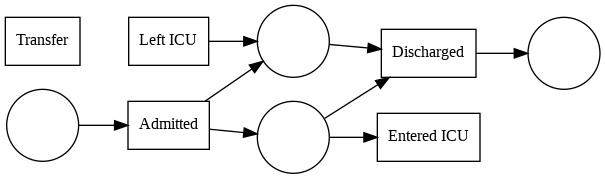

In [14]:
import graphviz
pm.view_petri_net(petri_net=net)

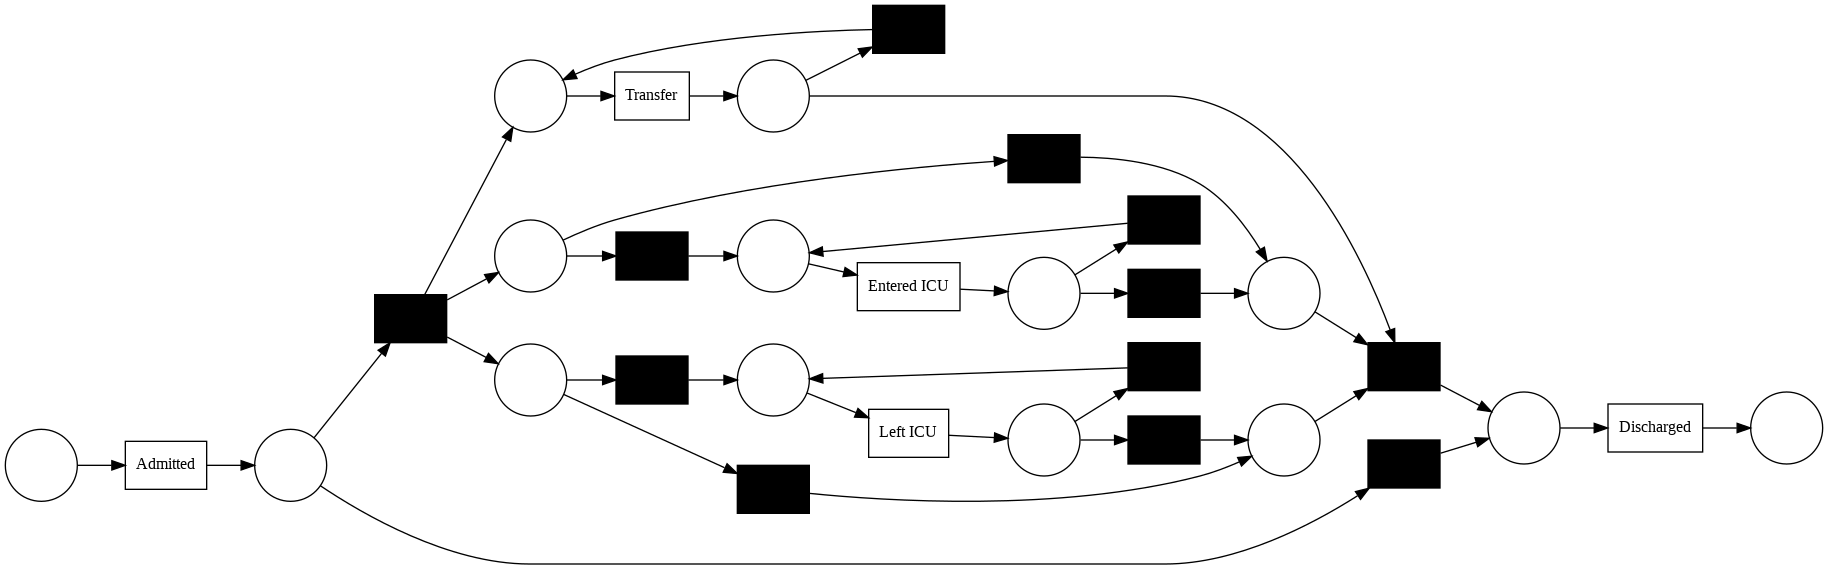

In [15]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

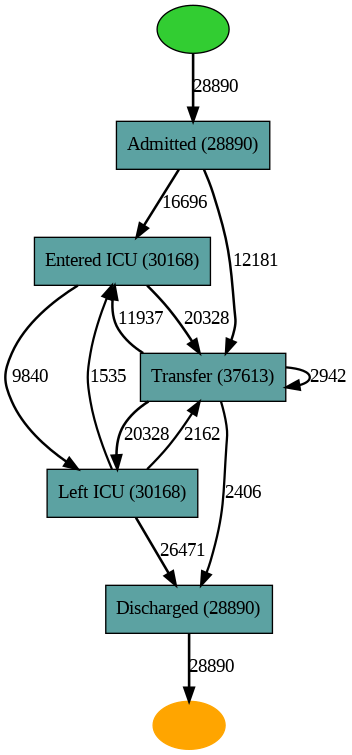

In [16]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

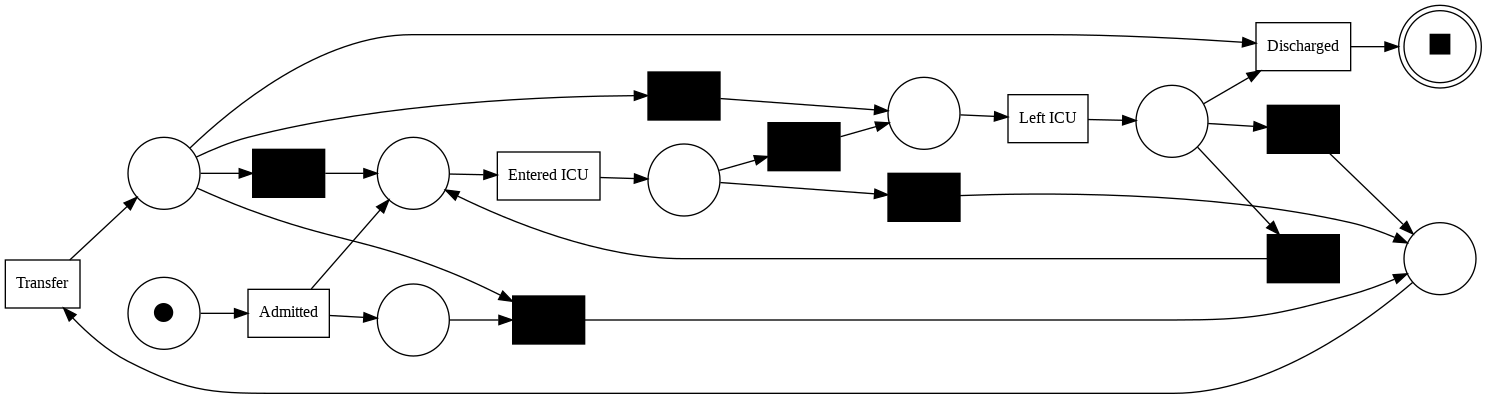

In [17]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

#Section 3: Preprocessing Data

In [27]:
from pandas.core.window.ewm import partial
import random

def partial_log(el, n):

  # select the first n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = event_log[event_log['trace'].isin(random_traces)]
  return partial_el.reset_index()


In [28]:
partial_el = partial_log(event_log, NUM_TRACES)
partial_el

,index,patient,activity,timestamp,case:concept:name,concept:name,time:timestamp,@@index,@@case_index,start_timestamp,trace
0,937,100399,Admitted,2168-04-18 13:28:00,100399,Admitted,2168-04-18 13:28:00,937,171,2168-04-18 13:28:00,126
1,938,100399,Entered ICU,2168-04-18 13:29:36,100399,Entered ICU,2168-04-18 13:29:36,938,171,2168-04-18 13:29:36,126
2,939,100399,Transfer,2168-04-18 13:29:36,100399,Transfer,2168-04-18 13:29:36,939,171,2168-04-18 13:29:36,126
3,940,100399,Left ICU,2168-04-22 10:41:38,100399,Left ICU,2168-04-22 10:41:38,940,171,2168-04-22 10:41:38,126
4,941,100399,Discharged,2168-04-23 18:05:00,100399,Discharged,2168-04-23 18:05:00,941,171,2168-04-23 18:05:00,126
...,...,...,...,...,...,...,...,...,...,...,...
536,230086,199767,Entered ICU,2129-06-04 00:27:45,199767,Entered ICU,2129-06-04 00:27:45,230086,42547,2129-06-04 00:27:45,28815
537,230087,199767,Transfer,2129-06-04 00:41:00,199767,Transfer,2129-06-04 00:41:00,230087,42547,2129-06-04 00:41:00,28815
538,230088,199767,Left ICU,2129-06-07 20:45:29,199767,Left ICU,2129-06-07 20:45:29,230088,42547,2129-06-07 20:45:29,28815
539,230089,199767,Transfer,2129-06-07 20:45:58,199767,Transfer,2129-06-07 20:45:58,230089,42547,2129-06-07 20:45:58,28815


In [29]:
from sklearn.model_selection import train_test_split
# select train and test traces
unique_traces = partial_el['trace'].unique()
train_traces, test_traces = train_test_split(unique_traces, test_size=TEST_SIZE, random_state=9)

train_el = partial_el.loc[partial_el['trace'].isin(train_traces)]
test_el = partial_el.loc[partial_el['trace'].isin(test_traces)]
test_el

,index,patient,activity,timestamp,case:concept:name,concept:name,time:timestamp,@@index,@@case_index,start_timestamp,trace
16,2098,100910,Admitted,2102-12-08 12:58:00,100910,Admitted,2102-12-08 12:58:00,2098,384,2102-12-08 12:58:00,270
17,2099,100910,Transfer,2102-12-08 12:59:39,100910,Transfer,2102-12-08 12:59:39,2099,384,2102-12-08 12:59:39,270
18,2100,100910,Entered ICU,2102-12-11 14:15:39,100910,Entered ICU,2102-12-11 14:15:39,2100,384,2102-12-11 14:15:39,270
19,2101,100910,Left ICU,2102-12-13 11:57:43,100910,Left ICU,2102-12-13 11:57:43,2101,384,2102-12-13 11:57:43,270
20,2102,100910,Discharged,2102-12-18 14:20:00,100910,Discharged,2102-12-18 14:20:00,2102,384,2102-12-18 14:20:00,270
...,...,...,...,...,...,...,...,...,...,...,...
514,222661,196415,Admitted,2169-09-08 22:44:00,196415,Admitted,2169-09-08 22:44:00,222661,41171,2169-09-08 22:44:00,27876
515,222662,196415,Transfer,2169-09-08 22:45:13,196415,Transfer,2169-09-08 22:45:13,222662,41171,2169-09-08 22:45:13,27876
516,222663,196415,Entered ICU,2169-09-11 09:28:10,196415,Entered ICU,2169-09-11 09:28:10,222663,41171,2169-09-11 09:28:10,27876
517,222664,196415,Left ICU,2169-09-14 14:29:48,196415,Left ICU,2169-09-14 14:29:48,222664,41171,2169-09-14 14:29:48,27876


In [30]:

unique_traces_test = test_el['trace'].unique()
traces = {x : pd.DataFrame() for x in unique_traces_test} 

for t in unique_traces_test:
  traces[t] = test_el[:][test_el.trace == t]




  

{270:     index  patient     activity           timestamp case:concept:name  \
 16   2098   100910     Admitted 2102-12-08 12:58:00            100910   
 17   2099   100910     Transfer 2102-12-08 12:59:39            100910   
 18   2100   100910  Entered ICU 2102-12-11 14:15:39            100910   
 19   2101   100910     Left ICU 2102-12-13 11:57:43            100910   
 20   2102   100910   Discharged 2102-12-18 14:20:00            100910   
 
    concept:name      time:timestamp  @@index  @@case_index  \
 16     Admitted 2102-12-08 12:58:00     2098           384   
 17     Transfer 2102-12-08 12:59:39     2099           384   
 18  Entered ICU 2102-12-11 14:15:39     2100           384   
 19     Left ICU 2102-12-13 11:57:43     2101           384   
 20   Discharged 2102-12-18 14:20:00     2102           384   
 
        start_timestamp  trace  
 16 2102-12-08 12:58:00    270  
 17 2102-12-08 12:59:39    270  
 18 2102-12-11 14:15:39    270  
 19 2102-12-13 11:57:43    270  
 20 